# Emoji Prediction using Deep Learning

####     

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras

In [ ]:
df = pd.read_csv("emoji.csv")
df.dropna(inplace=True)

In [ ]:
df.head(10)

,Tweet,Label
0,a little throwback with my favourite person w...,0
1,glam on yesterday for kcon makeup using in f...,7
2,democracy plaza in the wake of a stunning outc...,11
3,then amp now vilo walt disney magic kingdom,0
4,who never a galaxy far far away,2
5,dinner in fla tonight panseared salmon over c...,1
6,its my fav seniors last game congrats on beati...,8
7,i got to to go formal with my best friend phi...,0
8,cause i miss my little homies throwback cousin...,13
9,birthday kisses madison wisconsin,9


### Over-sampling data

In [ ]:
X = df["Tweet"].values
y = df["Label"].values

In [ ]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler()
X = X.reshape(-1,1)
X, y = os.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X = X.reshape(-1,)
X.shape

(215180,)

#   

### Tokenization

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X)

In [ ]:
X_seqs = tokenizer.texts_to_sequences(X)
X_seqs[:10]

[[4, 62, 473, 11, 3, 2316, 452, 658, 955],
 [4107, 17, 311, 10, 22846, 659, 1544, 6, 22847],
 [5253, 758, 6, 1, 1129, 9, 4, 1288, 9189, 4794, 6019, 1556],
 [530, 25, 90, 49393, 551, 231, 226, 357],
 [109, 141, 4, 3094, 783, 783, 576],
 [219,
  6,
  16886,
  82,
  43876,
  2828,
  217,
  43877,
  8302,
  1899,
  1891,
  219,
  89,
  43878],
 [31, 3, 557, 2127, 57, 195, 560, 17, 6020, 212, 212, 11970],
 [5, 56, 2, 2, 84, 1098, 11, 3, 53, 124, 1072, 3754, 13, 19594],
 [534, 5, 153, 3, 62, 1739, 473, 8734, 596, 49],
 [61, 1447, 767, 931]]

In [ ]:
idx2words = tokenizer.index_word

print("Word Mappings\n")
for i in range(1,10):
    print("Index: ",i, "---->",idx2words[i])

Word Mappings

Index:  1 ----> the
Index:  2 ----> to
Index:  3 ----> my
Index:  4 ----> a
Index:  5 ----> i
Index:  6 ----> in
Index:  7 ----> and
Index:  8 ----> you
Index:  9 ----> of


In [ ]:
vocab_size = len(tokenizer.index_word)
print("Vocabulary size :",len(tokenizer.index_word))

Vocabulary size : 62671


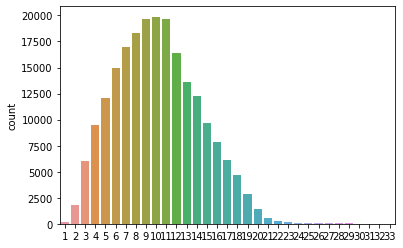

In [ ]:
lens = [len(seq) for seq in X_seqs]
sns.countplot(x=lens)
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_len=40

X_seqs_pd = pad_sequences(X_seqs, truncating="pre", padding="pre", maxlen=max_len)

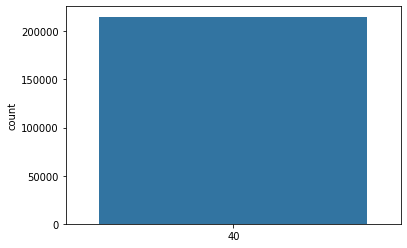

In [ ]:
lens = [len(seq) for seq in X_seqs_pd]
sns.countplot(x=lens)
plt.show()

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, y_test = train_test_split(X_seqs_pd, y, test_size=0.3, random_state=105)
print("Training X Dim ",X_train.shape)
print("Training y Dim ",y_train.shape)

print("Test X Dim ",X_test.shape)
print("Test y Dim ",y_test.shape)

Training X Dim  (150626, 40)
Training y Dim  (150626, 20)
Test X Dim  (64554, 40)
Test y Dim  (64554, 20)


#   

## Deep Learning  Model using LSTMs

In [64]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Bidirectional,Embedding, GlobalMaxPool1D



vocabulary_size = vocab_size
seq_len = 40
embed_len=20

model = Sequential()
model.add(Embedding(vocabulary_size+1, embed_len, input_length=seq_len))
model.add(LSTM(units = 80, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units = 40))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 20)            1253440   
_________________________________________________________________
lstm_6 (LSTM)                (None, 40, 80)            32320     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 40)                19360     
_________________________________________________________________
dropout_9 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                820       
Total params: 1,305,940
Trainable params: 1,305,940
Non-trainable params: 0
____________________________________________

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=1,verbose=1)

model.compile(loss = 'categorical_crossentropy',
             optimizer = "adam",
             metrics=["accuracy"])

In [ ]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [66]:

batch_size=128
epochs = 20

model.fit(X_train, y_train_cat, batch_size=batch_size, epochs = epochs, shuffle=True,
          validation_data=(X_test, y_test_cat), callbacks=[early_stop])

Epoch 1/20
1177/1177 [==============================] - 25s 21ms/step - loss: 2.4237 - accuracy: 0.2475 - val_loss: 1.7973 - val_accuracy: 0.4525
Epoch 2/20
1177/1177 [==============================] - 24s 20ms/step - loss: 1.4758 - accuracy: 0.5607 - val_loss: 1.1806 - val_accuracy: 0.6666
Epoch 3/20
1177/1177 [==============================] - 24s 20ms/step - loss: 0.9992 - accuracy: 0.7178 - val_loss: 0.9039 - val_accuracy: 0.7511
Epoch 4/20
1177/1177 [==============================] - 24s 21ms/step - loss: 0.7420 - accuracy: 0.7943 - val_loss: 0.7573 - val_accuracy: 0.7995
Epoch 5/20
1177/1177 [==============================] - 24s 21ms/step - loss: 0.5991 - accuracy: 0.8347 - val_loss: 0.7019 - val_accuracy: 0.8205
Epoch 6/20
1177/1177 [==============================] - 24s 20ms/step - loss: 0.5062 - accuracy: 0.8620 - val_loss: 0.6547 - val_accuracy: 0.8379
Epoch 7/20
1177/1177 [==============================] - 24s 20ms/step - loss: 0.4369 - accuracy: 0.8817 - val_loss: 0.6341 -

In [ ]:
model.evaluate(x_test, y_test, batch_size=batch_size)

In [67]:
loss = pd.DataFrame(model.history.history)
loss

,loss,accuracy,val_loss,val_accuracy
0,2.423696,0.247467,1.797268,0.452458
1,1.475779,0.560713,1.180616,0.666558
2,0.999234,0.717778,0.903867,0.751139
3,0.742029,0.794292,0.757338,0.799455
4,0.599075,0.834730,0.701901,0.820538
5,0.506225,0.861976,0.654693,0.837888
6,0.436892,0.881694,0.634060,0.849258
7,0.387615,0.894952,0.607426,0.861868
8,0.342276,0.907991,0.607691,0.866825


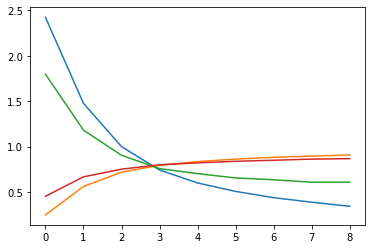

In [68]:
plt.plot(loss)

#    

## Deep Learning  Model using Bidirectional-LSTMs

In [15]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Bidirectional,Embedding, GlobalMaxPool1D



vocabulary_size = vocab_size
seq_len = 40
embed_len=128


model = Sequential()
model.add(Embedding(vocabulary_size+1, embed_len, input_length=seq_len))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           8022016   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 160)           133760    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 160)           154240    
_________________________________________________________________
global_max_pooling1d (Global (None, 160)               0         
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                10304     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=0,verbose=1)

model.compile(loss = 'categorical_crossentropy',
             optimizer = "adam",
             metrics=["accuracy"])

In [ ]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [18]:
batch_size=64
epochs = 15

model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs, 
          shuffle=True,validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/15
2354/2354 [==============================] - 224s 95ms/step - loss: 2.2879 - accuracy: 0.2940 - val_loss: 1.4041 - val_accuracy: 0.5763
Epoch 2/15
2354/2354 [==============================] - 223s 95ms/step - loss: 1.0589 - accuracy: 0.6898 - val_loss: 0.8214 - val_accuracy: 0.7561
Epoch 3/15
2354/2354 [==============================] - 223s 95ms/step - loss: 0.6128 - accuracy: 0.8237 - val_loss: 0.6235 - val_accuracy: 0.8254
Epoch 4/15
2354/2354 [==============================] - 223s 95ms/step - loss: 0.4133 - accuracy: 0.8837 - val_loss: 0.5428 - val_accuracy: 0.8616
Epoch 5/15
2354/2354 [==============================] - 222s 94ms/step - loss: 0.3023 - accuracy: 0.9167 - val_loss: 0.4961 - val_accuracy: 0.8795
Epoch 6/15
2354/2354 [==============================] - 222s 94ms/step - loss: 0.2319 - accuracy: 0.9374 - val_loss: 0.5038 - val_accuracy: 0.8874
Epoch 00006: early stopping


KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, y_test, batch_size=batch_size)

1009/1009 [==============================] - 7s 7ms/step - loss: 0.5038 - accuracy: 0.8874


[0.5403534173965454, 0.8935310244560242]

In [19]:
loss = pd.DataFrame(model.history.history)
loss

,loss,accuracy,val_loss,val_accuracy
0,2.2879,0.2940,1.4041,0.5763
1,1.0589,0.6898,0.8214,0.7561
2,0.6128,0.8237,0.6235,0.8254
3,0.4133,0.8837,0.5428,0.8616
4,0.3023,0.9167,0.4961,0.8795
5,0.2319,0.9374,0.5038,0.8874


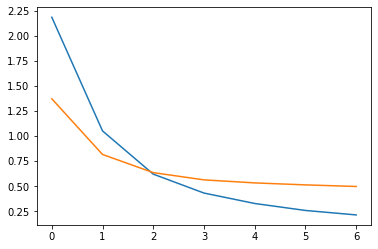

In [34]:
plt.plot(loss[["loss","val_loss"]])
plt.show()

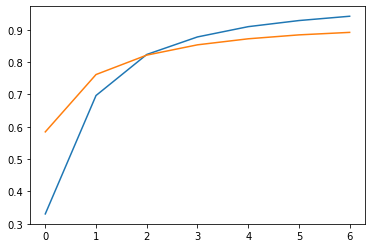

In [28]:
plt.plot(loss[["accuracy","val_accuracy"]])

## Model Evaluation

In [53]:
from sklearn.metrics import classification_report, confusion_matrix


predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.31      0.40      3211
           1       0.69      0.64      0.66      3249
           2       0.84      0.73      0.78      3240
           3       0.79      0.85      0.82      3175
           4       0.93      0.93      0.93      3208
           5       0.82      0.88      0.85      3281
           6       0.89      0.93      0.91      3255
           7       0.87      0.94      0.90      3172
           8       0.93      0.93      0.93      3273
           9       0.84      0.94      0.89      3226
          10       0.96      0.89      0.92      3202
          11       0.93      0.98      0.95      3216
          12       0.95      0.97      0.96      3277
          13       0.95      0.97      0.96      3202
          14       0.95      0.97      0.96      3225
          15       0.95      0.98      0.97      3177
          16       0.94      0.96      0.95      3234
          17       0.97    

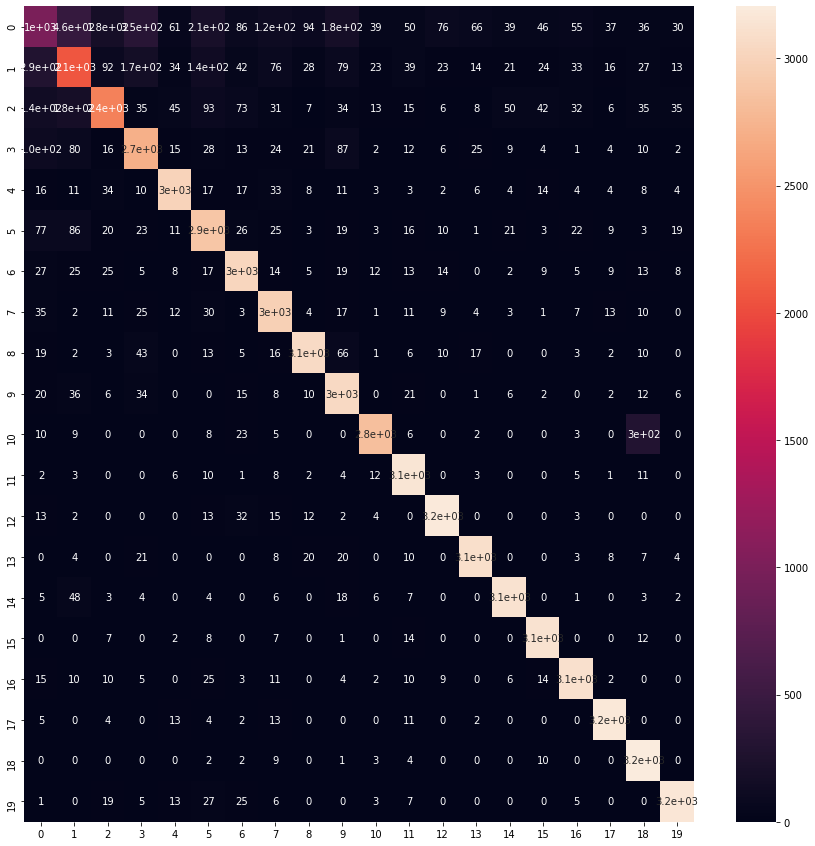

In [54]:
plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat, annot=True)                                                                   
plt.show()

In [49]:
model.save("BLSTM.h5")